In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlparse
import re

In [2]:
# Global variables
RND_SEED = 42

## General Log File

In [3]:
# Load "general log" file...
general_log = pd.read_json('data/general_log.json')

# ...and show a sample from this data
general_log.sample(10, random_state=RND_SEED)

,event_time,user_host,thread_id,server_id,command_type,argument
2726,2021-01-14 14:20:22.221548,guest[guest] @ [172.31.36.183],40,97408076,Query,select\n\t100.00 * sum(case\n\t\twhen p_type l...
15464,2021-01-14 11:31:39.847004,guest[guest] @ [172.31.36.183],20,97408076,Query,"select\n\tps_partkey,\n\tps_supplycost,\n\tps_..."
8314,2021-01-14 13:08:29.396154,rdsadmin[rdsadmin] @ localhost [127.0.0.1],9,97408076,Query,SELECT 1
8694,2021-01-14 13:03:44.398239,rdsadmin[rdsadmin] @ localhost [127.0.0.1],9,97408076,Query,SELECT value FROM mysql.rds_heartbeat2
8035,2021-01-14 13:11:59.413300,guest[guest] @ [172.31.36.183],40,97408076,Query,"select\n\tn_name,\n\tsum(l_extendedprice * (1 ..."
12715,2021-01-14 12:00:33.138725,guest[guest] @ [172.31.36.183],20,97408076,Query,select\n\tl_extendedprice\nfrom\n\tlineitem\nw...
3341,2021-01-14 14:12:28.012333,guest[guest] @ [172.31.36.183],40,97408076,Query,"select\n\ts_name,\n\ts_address\nfrom\n\tsuppli..."
6896,2021-01-14 13:26:02.562039,guest[guest] @ [172.31.36.183],40,97408076,Query,"select\n\tn_name,\n\tsum(l_extendedprice * (1 ..."
13082,2021-01-14 11:56:44.396006,rdsadmin[rdsadmin] @ localhost [127.0.0.1],9,97408076,Query,SELECT count(*) from information_schema.TABLES...
13767,2021-01-14 11:49:36.499635,guest[guest] @ [172.31.36.183],20,97408076,Query,"select\n\to_orderpriority,\n\tcount(*) as orde..."


In [4]:
# Deepening 'user_host' field
print(general_log['user_host'].describe())

count                                          16101
unique                                             7
top       rdsadmin[rdsadmin] @ localhost [127.0.0.1]
freq                                            9473
Name: user_host, dtype: object


In [5]:
# Show all the host (; prevent from printing the cell final value)
[print(x) for x in general_log['user_host'].unique()];

guest[guest] @  [185.9.209.177]
rdsadmin[rdsadmin] @ localhost [127.0.0.1]
rdsadmin[rdsadmin] @ localhost []
[rdsadmin] @ localhost []
[guest] @  [185.9.209.177]
guest[guest] @  [172.31.36.183]
[guest] @  [172.31.36.183]


Seven unique user in total had interacted with the DB (Non-Query included) and the `rdsadmin` a lot of time.  
By the way there are only two categories, "guest" and "rdsadmin".

In [6]:
# Deepening 'server_id' field
general_log['server_id'].astype(str).describe()

count        16101
unique           1
top       97408076
freq         16101
Name: server_id, dtype: object

The server is just one. 

### Comments on "general_log" file

- `event_time` show when the event is happened;
- `user_host`  the user (name and addr) that caused the event, may be choosen as predictor...
- `thread_id`  the thread assigned to the associated process on server, not useful for prediction i guess...
- `server_id`  the server identification name, looks like is always the same, not useful;
- `command_type` we are interested in `Query` command types wich is the majority, not a useful field for predicion...
- `argument` when is a Query contains a SQL expression and we should extract more features from this.

Let's see the "slow log" file...

## Slow Log File

In [7]:
# Load "slow log" file...
slow_log = pd.read_json('data/slow_log.json')

# ...and show a sample from this data
slow_log.sample(10, random_state=RND_SEED)

,start_time,user_host,query_time,lock_time,rows_sent,rows_examined,db,last_insert_id,insert_id,server_id,sql_text,thread_id
15183,2021-01-14 11:30:14.408956,rdsadmin[rdsadmin] @ localhost [127.0.0.1],2021-05-09 00:00:00.000272,2021-05-09 00:00:00.000000,1,1,,0,0,97408076,SELECT @@session.transaction_read_only,9
4469,2021-01-14 13:52:29.665484,guest[guest] @ [172.31.36.183],2021-05-09 00:00:00.105779,2021-05-09 00:00:00.000189,514,258355,tpch,0,0,97408076,"select\n\ts_acctbal,\n\ts_name,\n\tn_name,\n\t...",40
9316,2021-01-14 12:40:14.395067,rdsadmin[rdsadmin] @ localhost [127.0.0.1],2021-05-09 00:00:00.000067,2021-05-09 00:00:00.000000,1,1,,0,0,97408076,SELECT 1,9
4983,2021-01-14 13:45:52.956110,guest[guest] @ [172.31.36.183],2021-05-09 00:00:03.594086,2021-05-09 00:00:00.000188,34,150068,tpch,0,0,97408076,"select\n\tc_count,\n\tcount(*) as custdist\nfr...",40
13154,2021-01-14 11:51:34.649361,guest[guest] @ [172.31.36.183],2021-05-09 00:00:00.412085,2021-05-09 00:00:00.000125,5,1500005,tpch,0,0,97408076,"select\n\to_orderpriority,\n\tcount(*) as orde...",20
10838,2021-01-14 12:15:59.397640,rdsadmin[rdsadmin] @ localhost [127.0.0.1],2021-05-09 00:00:00.001623,2021-05-09 00:00:00.000701,1,4,,0,0,97408076,SELECT count(*) from information_schema.TABLES...,9
3013,2021-01-14 14:11:38.937663,guest[guest] @ [172.31.36.183],2021-05-09 00:00:00.110873,2021-05-09 00:00:00.000202,482,258979,tpch,0,0,97408076,"select\n\ts_acctbal,\n\ts_name,\n\tn_name,\n\t...",40
10957,2021-01-14 12:14:46.858026,guest[guest] @ [172.31.36.183],2021-05-09 00:00:02.594780,2021-05-09 00:00:00.000231,2537,1780036,tpch,0,0,97408076,"select\n\to_year,\n\tcase\n\t\twhen nation = '...",20
9767,2021-01-14 12:28:59.398117,rdsadmin[rdsadmin] @ localhost [127.0.0.1],2021-05-09 00:00:00.000080,2021-05-09 00:00:00.000000,1,1,,0,0,97408076,SELECT 1,9
11469,2021-01-14 12:09:31.483985,guest[guest] @ [172.31.36.183],2021-05-09 00:00:02.350517,2021-05-09 00:00:00.000219,2420,1789230,tpch,0,0,97408076,"select\n\to_year,\n\tcase\n\t\twhen nation = '...",20


In [8]:
# Deepening 'user_host' field (now in the dataset)
slow_log['user_host'].describe()

count                                          15688
unique                                             4
top       rdsadmin[rdsadmin] @ localhost [127.0.0.1]
freq                                            9160
Name: user_host, dtype: object

In [9]:
slow_log['user_host'].unique()

array(['guest[guest] @  [185.9.209.177]',
       'rdsadmin[rdsadmin] @ localhost [127.0.0.1]',
       'rdsadmin[rdsadmin] @ localhost []',
       'guest[guest] @  [172.31.36.183]'], dtype=object)

We should aggregate this in just two categories: `guest` and `admin`.

In [10]:
# Deepening 'sql_text' field
slow_log['sql_text'].describe()

count        15688
unique        3803
top       SELECT 1
freq          5413
Name: sql_text, dtype: object

`SELECT 1` query is executed more often than the others, let's see if has a fixed execution time or depends on when it is executed...

In [11]:
# Query time conversion
def query_time_converer(df):    
    time = df['query_time'].dt.hour * 3600 
    time += df['query_time'].dt.minute * 60
    time += df['query_time'].dt.second
    time += df['query_time'].dt.microsecond * 1e-6
    time += df['query_time'].dt.nanosecond * 1e-9
    time /= 1e-6 # To microseconds
    df['query_time'] = time

In [12]:
# Extract all SELECT 1 timings
select_timings = slow_log[['sql_text', 'query_time']].loc[slow_log['sql_text'] == 'SELECT 1'].copy()
query_time_converer(select_timings)

# Mean executution time of SELECT 1
print('Mean execution time of SELECT 1:', round(select_timings['query_time'].mean(), 2), 'microseconds')

# Standard deviation for execution time of SELECT 1
print('Standard deviation :', round(select_timings['query_time'].std(), 2), 'microseconds')

Mean execution time of SELECT 1: 1009.65 microseconds
Standard deviation : 3838.58 microseconds


Execution time of such a simple query has a relative low mean but high standard deviation, this means can be very variable around mean value depending on when is executed.

### Comments on "slow_log" file

- `start_time` is the time when the timer start, may be used as order key if considering a time series of events;
- `user_host` same as general log seen before;
- `query_time` the total time the query takes, this should be the target variable for the model (needs some conversion);
- `lock_time` the time the query spend locking resources in DB i guess, is a sub-time of query time (?);
- `rows_sent` the number of rows returned from the query, using this as predictor may cause data leak in prediction;
- `rows_examined` similar to `rows_sent` show the rows the query iterate before returning (maybe looking up for some condition), using this for prediction may lead to data leak (model perform well on test then degenerate in production);
- `db` the db name, since all queries are generated I think this field is not important;
- `last_insert_id` the id of last inserted or updated row in a table by this query (?);
- `insert_id` the id of first inserted or update row in a table by this query (?);
- `server_id` same as general log seen before;
- `sql_text` same as `argument` field in general log when the event is a Query type, contains the SQL query code;
- `thread_id` same as general log seen before.

First impression is that for the task of predicting query execution time I need just the "slow_log" file since it contains all the useful information to extract features and train a model. Not only slow queries are recorded but also that one with 0 execution time. Number of samples is a bit low so may be necessary a cross-validation for better evaluation. To exploit rows_sent and rows_examinated is tempting but we know this values only after the query execute so in a real context we receive a query without no knowledge about the number of rows will be used till the end of execution.

## Dataset feature selection/engineering

In [13]:
# Define the raw dataset...
dataset = slow_log[['start_time', 'user_host', 'sql_text', 'query_time']].copy()

# ...and show a sample
dataset.sample(10, random_state=RND_SEED)

,start_time,user_host,sql_text,query_time
15183,2021-01-14 11:30:14.408956,rdsadmin[rdsadmin] @ localhost [127.0.0.1],SELECT @@session.transaction_read_only,2021-05-09 00:00:00.000272
4469,2021-01-14 13:52:29.665484,guest[guest] @ [172.31.36.183],"select\n\ts_acctbal,\n\ts_name,\n\tn_name,\n\t...",2021-05-09 00:00:00.105779
9316,2021-01-14 12:40:14.395067,rdsadmin[rdsadmin] @ localhost [127.0.0.1],SELECT 1,2021-05-09 00:00:00.000067
4983,2021-01-14 13:45:52.956110,guest[guest] @ [172.31.36.183],"select\n\tc_count,\n\tcount(*) as custdist\nfr...",2021-05-09 00:00:03.594086
13154,2021-01-14 11:51:34.649361,guest[guest] @ [172.31.36.183],"select\n\to_orderpriority,\n\tcount(*) as orde...",2021-05-09 00:00:00.412085
10838,2021-01-14 12:15:59.397640,rdsadmin[rdsadmin] @ localhost [127.0.0.1],SELECT count(*) from information_schema.TABLES...,2021-05-09 00:00:00.001623
3013,2021-01-14 14:11:38.937663,guest[guest] @ [172.31.36.183],"select\n\ts_acctbal,\n\ts_name,\n\tn_name,\n\t...",2021-05-09 00:00:00.110873
10957,2021-01-14 12:14:46.858026,guest[guest] @ [172.31.36.183],"select\n\to_year,\n\tcase\n\t\twhen nation = '...",2021-05-09 00:00:02.594780
9767,2021-01-14 12:28:59.398117,rdsadmin[rdsadmin] @ localhost [127.0.0.1],SELECT 1,2021-05-09 00:00:00.000080
11469,2021-01-14 12:09:31.483985,guest[guest] @ [172.31.36.183],"select\n\to_year,\n\tcase\n\t\twhen nation = '...",2021-05-09 00:00:02.350517


In [14]:
# Sort values by time 
dataset.sort_values(by='start_time', inplace=True, ignore_index=True)
dataset.head(5)

,start_time,user_host,sql_text,query_time
0,2021-01-14 11:20:54.690597,guest[guest] @ [185.9.209.177],/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-05-09 00:00:00.181089
1,2021-01-14 11:20:54.934096,guest[guest] @ [185.9.209.177],SHOW WARNINGS,2021-05-09 00:00:00.000102
2,2021-01-14 11:20:54.995957,guest[guest] @ [185.9.209.177],SELECT @@session.transaction_isolation,2021-05-09 00:00:00.000091
3,2021-01-14 11:20:59.393082,rdsadmin[rdsadmin] @ localhost [127.0.0.1],SELECT 1,2021-05-09 00:00:00.000147
4,2021-01-14 11:20:59.393973,rdsadmin[rdsadmin] @ localhost [127.0.0.1],SELECT 1,2021-05-09 00:00:00.000074


In [15]:
# Aggregating user hosts in two categories: guest and admin
dataset['user_host'] = dataset['user_host'].apply(lambda h: 'admin' if 'admin' in h else 'guest')
dataset.head(5)

,start_time,user_host,sql_text,query_time
0,2021-01-14 11:20:54.690597,guest,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-05-09 00:00:00.181089
1,2021-01-14 11:20:54.934096,guest,SHOW WARNINGS,2021-05-09 00:00:00.000102
2,2021-01-14 11:20:54.995957,guest,SELECT @@session.transaction_isolation,2021-05-09 00:00:00.000091
3,2021-01-14 11:20:59.393082,admin,SELECT 1,2021-05-09 00:00:00.000147
4,2021-01-14 11:20:59.393973,admin,SELECT 1,2021-05-09 00:00:00.000074


In [16]:
# Query execution time conversion
query_time_converer(dataset)
dataset.head(5)

,start_time,user_host,sql_text,query_time
0,2021-01-14 11:20:54.690597,guest,/* ApplicationName=DataGrip 2020.2.3 */ select...,181089.0
1,2021-01-14 11:20:54.934096,guest,SHOW WARNINGS,102.0
2,2021-01-14 11:20:54.995957,guest,SELECT @@session.transaction_isolation,91.0
3,2021-01-14 11:20:59.393082,admin,SELECT 1,147.0
4,2021-01-14 11:20:59.393973,admin,SELECT 1,74.0


#### Feature extraction

In [17]:
# All queries to lowercase
dataset['sql_text'] = dataset['sql_text'].apply(lambda q: str.lower(q))
dataset.sample(3, random_state=RND_SEED)

,start_time,user_host,sql_text,query_time
15183,2021-01-14 15:00:29.394436,admin,select count(*) from information_schema.tables...,732.0
4469,2021-01-14 12:12:00.045871,admin,select 1,2597.0
9316,2021-01-14 13:27:59.398411,admin,select count(*) from information_schema.tables...,1560.0


In [18]:
# Categorical features: Tables accessed by query

# Table names has been grabbed from DDL File
cat_patterns = {'use customer': r'customer',
                'use lineitem': r'lineitem', 
                'use nation': r'nation', 
                'use orders': r'orders',
                'use part': r'part',
                'use partsupp': r'partsupp',
                'use region': r'region',
                'use supplier': r'supplier'}

for cname, pt in cat_patterns.items():
    dataset[cname.replace(' ', '_')] = dataset['sql_text'].apply(lambda q: 'yes' if re.search(pt, q) else 'no')

In [19]:
# Numeric feature: Query number of chars
dataset['charlen'] = dataset['sql_text'].apply(lambda q: len(q))

In [20]:
# Numeric feature: Query number of tokens (this take some seconds)
dataset['num_tokens'] = dataset['sql_text'].apply(lambda q: len(sqlparse.parse(q)[0].tokens))

In [21]:
# Numeric features: Count nested queries or repetition
patterns = {'num functions': r'[a-z]+\(.*\)',            
            'num select': r'\s?select\s',
            'num from': r'\s?from\s',
            'num where': r'\s?where\s',            
            'num join': r'join',
            'num order by': r'\sorder by\s'}
    
for cname, pt in patterns.items():
    dataset[cname.replace(' ', '_')] = dataset['sql_text'].apply(lambda q: len(re.findall(pt, q)) )

In [22]:
# Show a dataset sample
dataset.sample(100, random_state=RND_SEED)

,start_time,user_host,sql_text,query_time,use_customer,use_lineitem,use_nation,use_orders,use_part,use_partsupp,use_region,use_supplier,charlen,num_tokens,num_functions,num_select,num_from,num_where,num_join,num_order_by
15183,2021-01-14 15:00:29.394436,admin,select count(*) from information_schema.tables...,732.0,no,no,no,no,no,no,no,no,109,9,1,1,1,1,0,0
4469,2021-01-14 12:12:00.045871,admin,select 1,2597.0,no,no,no,no,no,no,no,no,8,3,0,1,0,0,0,0
9316,2021-01-14 13:27:59.398411,admin,select count(*) from information_schema.tables...,1560.0,no,no,no,no,no,no,no,no,109,9,1,1,1,1,0,0
4983,2021-01-14 12:17:18.085426,guest,"select\n\tp_brand,\n\tp_type,\n\tp_size,\n\tps...",277364.0,no,no,no,no,yes,yes,no,no,209,11,0,1,1,1,0,0
13154,2021-01-14 14:17:57.451075,guest,"select\n\ts_name,\n\tcount(*) as numwait\nfrom...",838041.0,no,yes,yes,yes,no,no,no,yes,619,20,1,3,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,2021-01-14 11:31:57.460933,guest,"select\n\ts_name,\n\ts_address\nfrom\n\tsuppli...",219178.0,no,yes,yes,no,yes,yes,no,yes,563,15,1,4,4,4,0,1
5440,2021-01-14 12:22:27.809810,guest,"select\n\tl_extendedprice\nfrom\n\tlineitem,\n...",80827.0,no,yes,no,no,yes,no,no,no,131,11,0,1,1,1,0,0
542,2021-01-14 11:30:35.291227,guest,"select\n\tl_extendedprice, \n\tl_discount\nfro...",141501.0,no,yes,no,no,yes,no,no,no,919,11,0,1,1,1,0,0
88,2021-01-14 11:23:14.393171,admin,select 1,83.0,no,no,no,no,no,no,no,no,8,3,0,1,0,0,0,0


## Plotting

In [23]:
# Plot settings
sns.set_color_codes('bright') # Color palette
sns.set(font_scale=1.2) # Font size
sns.set_style("white") # Whithe background with lines

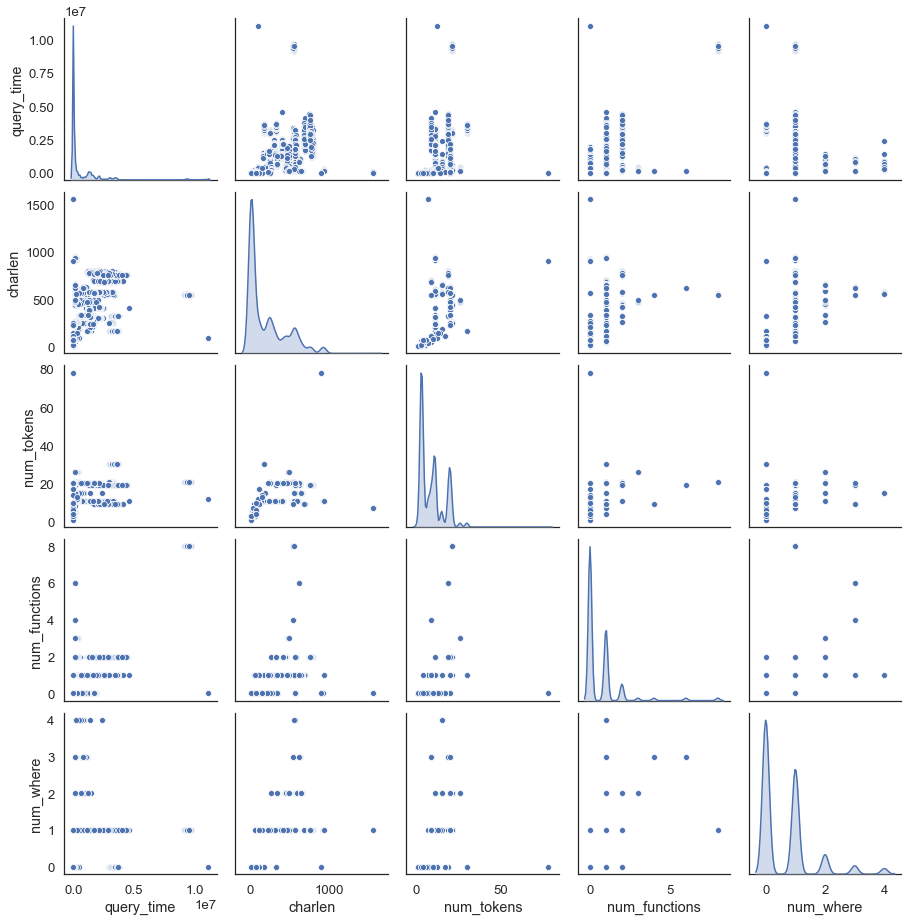

In [24]:
# Plot relations between numerical features in data, univariate distribution on diagonal.
pplot = sns.pairplot(data=dataset[['query_time', 'charlen', 'num_tokens', 'num_functions', 'num_where']], 
                     diag_kind='kde')

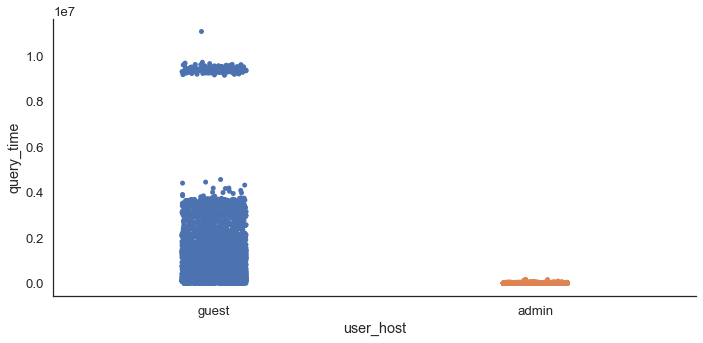

In [25]:
# Plot user_host by query times distribution
ax = sns.catplot(x='user_host', y='query_time', data=dataset, height=5, aspect=2)

It's clear that some guest users are slowing down the DB with particular queries, some queries perform way badly respect to others.

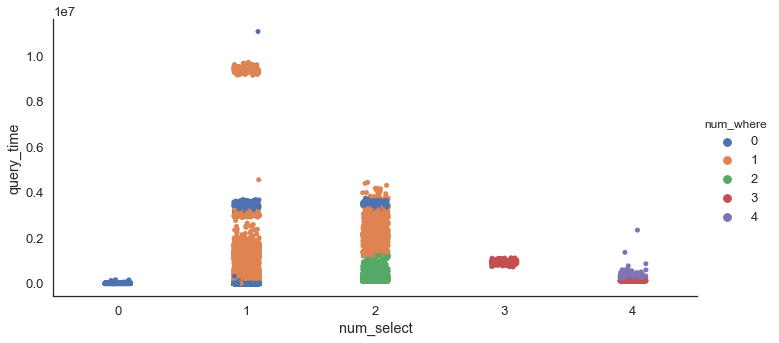

In [26]:
ax = sns.catplot(x='num_select', y='query_time', hue='num_where', data=dataset, height=5, aspect=2)

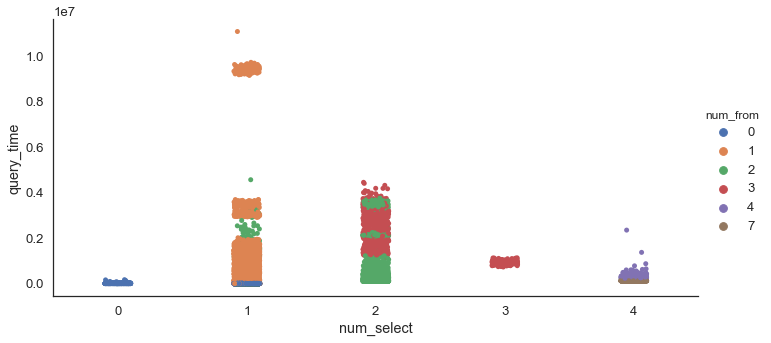

In [27]:
ax = sns.catplot(x='num_select', y='query_time', hue='num_from', data=dataset, height=5, aspect=2)

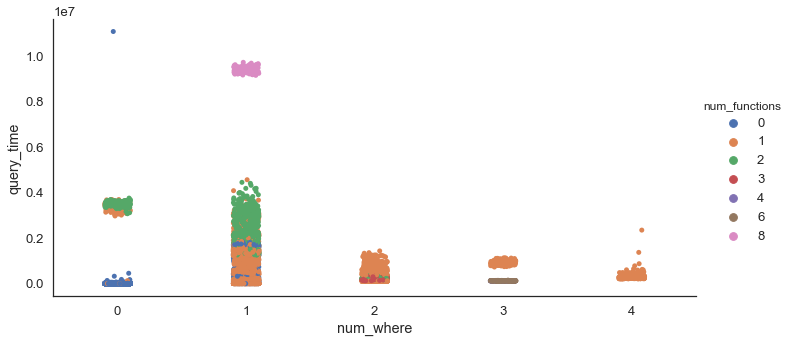

In [28]:
ax = sns.catplot(x='num_where', y='query_time', hue='num_functions', data=dataset, height=5, aspect=2)

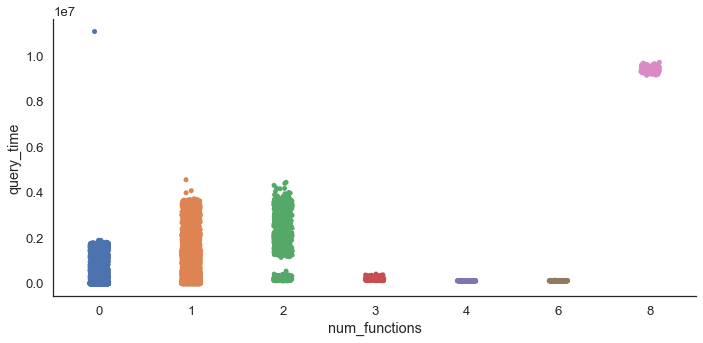

In [29]:
ax = sns.catplot(x='num_functions', y='query_time', data=dataset, height=5, aspect=2)

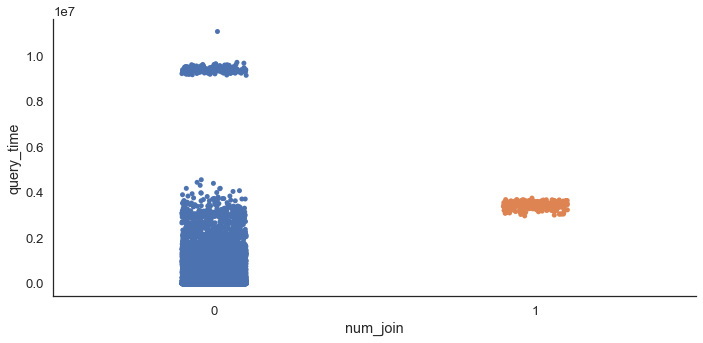

In [30]:
sx = sns.catplot(x='num_join', y='query_time', data=dataset, height=5, aspect=2)

## Save dataset for model training

In [31]:
dataset.to_csv('queries_dataset.csv', index=False)